In [2]:
import pandas as pd
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
df = pd.read_csv('/data/home/yyma/KGC-project/CM-BKG/data/raw/extracted_data_entity_text_yz.csv')
tri_path = '/data/home/yyma/KGC-project/CM-BKG/data/remove_assay/train.csv'

tri_df = pd.read_csv(tri_path)

/tmp/ipykernel_1128164/353517025.py:5: DtypeWarning: Columns (2,3,4,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/data/home/yyma/KGC-project/CM-BKG/data/raw/extracted_data_entity_text_yz.csv')


In [3]:
# calculate the relations 
tri_rels = tri_df['_type'].value_counts()
rel_count_df = tri_rels.reset_index()
rel_count_df.columns = ['Label', 'Count']


In [4]:
top30_types = tri_rels.nlargest(30).index
filtered_df = tri_df[tri_df['_type'].isin(top30_types)]

([<matplotlib.patches.Wedge at 0x7696ef864410>,
 [Text(-0.39704778791840867, 1.025842606889136, ':Gene'),
  Text(0.39704763302047996, -1.0258426668416725, ':Disease')],
 [Text(-0.21657152068276833, 0.5595505128486196, '61.8%'),
  Text(0.21657143619298905, -0.559550545550003, '38.2%')])

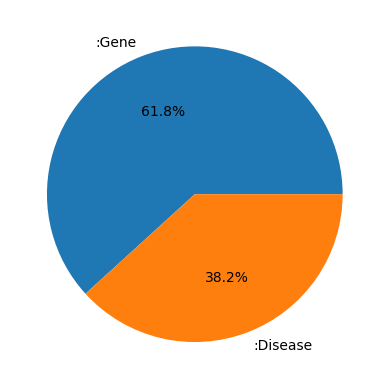

In [5]:
import matplotlib.pyplot as plt

node_set = set()
for index, tri in tri_df.loc[tri_df['_type'] == "ASSOCIATES_DaG"].iterrows():
    node_set.add(tri['_start'])  # Add the _start node to the set
    node_set.add(tri['_end'])

dag_df = df[df['_id'].isin(node_set)][['_id', '_labels']]

node_counts = dag_df['_labels'].value_counts()
plt.pie(node_counts, labels=node_counts.index, autopct='%1.1f%%')

In [6]:
#lets do edge-wise sampling
top_30rels = list(filtered_df["_type"].unique())

subgraph_edges = pd.DataFrame()

num = int(len(filtered_df) * 0.005 / len(top_30rels))

for rel in top_30rels:
    rel_edges = filtered_df[filtered_df['_type'] == rel].sample(n=num, replace=False)
    subgraph_edges = pd.concat([subgraph_edges, rel_edges])

([<matplotlib.patches.Wedge at 0x7c2de091de50>,
 [Text(1.093974083713357, 0.11498132093310277, 'COULD_NOT_BE_ACTIVE_IN_CiaiO'),
  Text(1.046162154822638, 0.33991873413634466, 'PRESENTS_DpS'),
  Text(0.9526279033665705, 0.5500000706612792, 'IS_EXPRESSED_IN_GieiA'),
  Text(0.8174592491392136, 0.7360437323941786, 'IS_ACTIVE_IN_CiaiCL'),
  Text(0.6465637011386807, 0.8899187493079641, 'BINDS_WITH_CbwP'),
  Text(0.447410275171291, 1.0049000177486065, 'INTERACTS_CiC'),
  Text(0.2287028191386328, 1.0759623694711826, 'INTERACTS_WITH_PiwP'),
  Text(-4.8082529002048655e-08, 1.099999999999999, 'HAS_GhGV'),
  Text(-0.22870304146695908, 1.075962322213823, 'COULD_NOT_BE_ACTIVE_IN_CiaiCL'),
  Text(-0.44741036302244247, 1.0048999786347528, 'IS_ACTIVE_IN_CiaiO'),
  Text(-0.6465639380677015, 0.8899185771689371, 'ASSOCIATES_PWaM'),
  Text(-0.8174592696145774, 0.7360437096539864, 'COULD_NOT_BIND_WITH_CnbwP'),
  Text(-0.9526280497967484, 0.5499998170367368, 'ASSOCIATES_DaV'),
  Text(-1.0461621541481756, 0.3

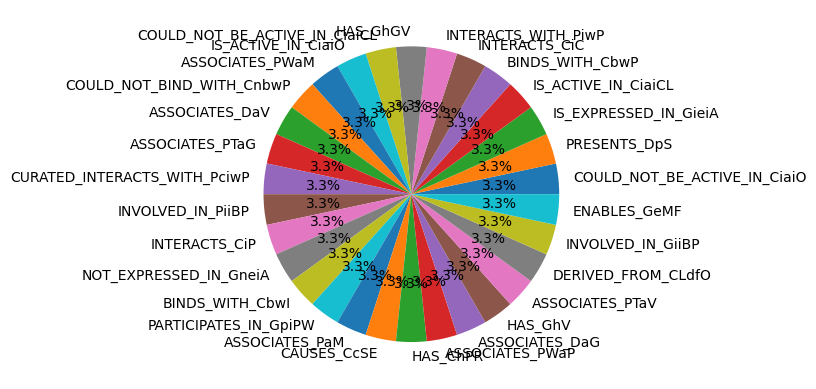

In [65]:
subgraph_rels = subgraph_edges['_type'].value_counts()
plt.pie(subgraph_rels, labels=subgraph_rels.index, autopct='%1.1f%%')

In [70]:
out_path = '/data/home/yyma/KGC-project/CM-BKG/data/partitions/edge_wise/test.csv'

subgraph_edges = subgraph_edges[['_start', '_type', '_end']]

# Save to CSV (without index)
subgraph_edges.to_csv(out_path, index=False, header=False, sep='\t')


In [9]:
import networkx as nx

G = nx.DiGraph()

for _, row in subgraph_edges.iterrows():
    G.add_edge(row['_start'], row['_end'], relation=row['_type'])

avg_in_degree = sum(dict(G.in_degree()).values()) / G.number_of_nodes()
avg_out_degree = sum(dict(G.out_degree()).values()) / G.number_of_nodes()
print(f"Average in-drgree is {avg_in_degree}, out_drgree is {avg_out_degree}")

# Diameter of the graph (only for connected components)
if nx.is_connected(G.to_undirected()):
    diameter = nx.diameter(G.to_undirected())
    print("Diameter of the graph:", diameter)
else:
    print("Graph is not connected, cannot compute diameter for the whole graph.")

# Graph density (ratio of edges to possible edges)
density = nx.density(G)
print("Graph density:", density)

# Average clustering coefficient
clustering_coeff = nx.average_clustering(G.to_undirected())
print("Average clustering coefficient:", clustering_coeff)

# Number of weakly connected components
num_weakly_connected_components = nx.number_weakly_connected_components(G)
print("Number of weakly connected components:", num_weakly_connected_components)

# Number of nodes
num_nodes = G.number_of_nodes()
print("Number of nodes:", num_nodes)

# Number of edges
num_edges = G.number_of_edges()
print("Number of edges:", num_edges)

# Average shortest path length (only if graph is connected)
if nx.is_connected(G.to_undirected()):
    avg_shortest_path_length = nx.average_shortest_path_length(G.to_undirected())
    print("Average shortest path length:", avg_shortest_path_length)



Average in-drgree is 1.1646045396045397, out_drgree is 1.1646045396045397
Graph is not connected, cannot compute diameter for the whole graph.
Graph density: 8.516241487115558e-06
Average clustering coefficient: 0.00016001305803667087
Number of weakly connected components: 7448
Number of nodes: 136752
Number of edges: 159262
